# Valuation Under Independent t-Distributed Assumptions

This notebook contains the empricial extensions described in Section 8.1 of the paper "What is the value of experimentation and measurement?"

> We extend the model to incorporate the heavy tail in the distribution of uplifts shown in related work by modelling the true value of the propositions, as well as the estimation noise, with Generalized Student’s t-distributions.

In [5]:
import rulu.normal_normal_model as nnm
import rulu.t_t_model as ttm
from rulu.utils import get_test_params
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Case study - comparison of t-distributed / normal assumptions

In [6]:
def get_normal_t_improvement_against_M(
    N, mu_X, sigma_X, mu_epsilon, sigma_1, sigma_2, M_list, verbose=False):
    
    # Constants
    NUM_RUNS = 10000
    T_DF = 3
    CI_HIGH_PERCENTILE = 95
    CI_LOW_PERCENTILE = 5    
    
    # Some functions take sigma, some take sigma squared
    sigma_sq_1 = sigma_1 ** 2
    sigma_sq_2 = sigma_2 ** 2
    sigma_sq_X = sigma_X ** 2
    
    # Initialise empty list to hold the results
    normal_E_Ds = []
    normal_CI_lows = []
    normal_CI_highs = []
    t_E_Ds = []
    t_CI_lows = []
    t_CI_highs = []
    
    print("Parameters: N = {}, mu_X = {}, sigma_X = {}, "
      "mu_epsilon = {}, sigma_1 = {}, sigma_2 = {}"
      .format(N, mu_X, sigma_X, mu_epsilon, sigma_1, sigma_2))

    for M in M_list:
        # Normal assumptions
        normal_improvement = (
            nnm.get_samples(
                n_samples=NUM_RUNS, N=N, M=M, 
                mu_X=mu_X, mu_epsilon=mu_epsilon, 
                sigma_sq_X=sigma_sq_X, sigma_sq_1=sigma_sq_1,
                sigma_sq_2=sigma_sq_2, verbose=False)['improvement']
        )

        normal_E_D = np.mean(normal_improvement)
        normal_CI_low = np.percentile(normal_improvement, CI_LOW_PERCENTILE)
        normal_CI_high = np.percentile(normal_improvement, CI_HIGH_PERCENTILE)

        normal_E_Ds.append(normal_E_D)
        normal_CI_lows.append(normal_CI_low)
        normal_CI_highs.append(normal_CI_high)
        
        # t-assumptions
        t_improvement = (
            ttm.get_samples(
                n_samples=NUM_RUNS, N=N, M=M, 
                mu_X=mu_X, mu_epsilon=mu_epsilon, 
                sigma_sq_X=sigma_sq_X, sigma_sq_1=sigma_sq_1,
                sigma_sq_2=sigma_sq_2, nu=T_DF, verbose=False)['improvement']
        )
        
        t_E_D = np.mean(t_improvement)
        t_CI_low = np.percentile(t_improvement, 5)
        t_CI_high = np.percentile(t_improvement, 95)

        t_E_Ds.append(t_E_D)
        t_CI_lows.append(t_CI_low)
        t_CI_highs.append(t_CI_high)
        
        if verbose:
            print("M = {}: normal improvement = {} ([{}, {}]), t improvement {} ([{}, {}])"
                  .format(M, np.round(normal_E_D, 3), 
                          np.round(normal_CI_low, 3), np.round(normal_CI_high, 3),
                          np.round(t_E_D, 3), np.round(t_CI_low, 3), np.round(t_CI_high, 3)))
            
    # Prepare result in a dict
    result = {
        'normal_E_Ds': normal_E_Ds,
        'normal_CI_lows': normal_CI_lows,
        'normal_CI_highs': normal_CI_highs,
        't_E_Ds': t_E_Ds,
        't_CI_lows': t_CI_lows,
        't_CI_highs': t_CI_highs,
    }
            
    return result


def generate_normal_t_improvement_against_M_plot(M_list, result):
    fig, ax = plt.subplots()
    
    ax.errorbar(result['normal_E_Ds'], M_list, 
                xerr=[np.array(result['normal_E_Ds']) - np.array(result['normal_CI_lows']), 
                      np.array(result['normal_CI_highs']) - np.array(result['normal_E_Ds'])],
                fmt='x', capsize=3)
    
    # Slightly displace the mean and error bar under t-distributed assumptions
    # so that it will be visible
    ax.errorbar(result['t_E_Ds'], 
                (np.array(M_list) * 1.1 if params['N'] > 500 else np.array(M_list) + 2), 
                xerr=[np.array(result['t_E_Ds']) - np.array(result['t_CI_lows']), 
                      np.array(result['t_CI_highs']) - np.array(result['t_E_Ds'])],
                fmt='^', capsize=3, alpha=0.85)
    
    ax.axvline(0, c='black')
    
    # The zero line has to be visible
    ax.set_xlim(min(min(result['normal_CI_lows'])-0.01, min(result['t_CI_lows'])-0.01, -0.01) * 1.05, 
                max(max(result['normal_CI_highs']), max(result['t_CI_highs']), 0.01) * 1.05)
    
    if params['N'] > 1000:
        ax.set_yscale('log')
    
#     ax.set_xlabel('Value gained')
#     ax.set_ylabel('M')
    
    return fig, ax

In [7]:
params_list = [
    {'N': 6700, 'mu_X': 0, 'mu_eps': 0, 'sigma_X': 0.6, 'sigma_1': 1, 'sigma_2': 0.4,
     'M': [10, 20, 50, 100, 200, 500, 1000], 'name':'ecomm'},
    {'N': 6700, 'mu_X': 0, 'mu_eps': 0, 'sigma_X': 0.6, 'sigma_1': 0.6, 'sigma_2': 0.4,
     'M': [10, 20, 50, 100, 200, 500, 1000], 'name':'ecomm'},
    {'N': 184, 'mu_X': 19.9, 'mu_eps': 0, 'sigma_X': 10, 'sigma_1': 2, 'sigma_2': 0.4, 
     'M': [10, 20, 40, 60, 80, 100], 'name':'marketing'},
    {'N': 184, 'mu_X': 19.9, 'mu_eps': 0, 'sigma_X': 10, 'sigma_1': 0.8, 'sigma_2': 0.4, 
     'M': [10, 20, 40, 60, 80, 100], 'name':'marketing'},
]

Parameters: N = 6700, mu_X = 0, sigma_X = 0.6, mu_epsilon = 0, sigma_1 = 1, sigma_2 = 0.4
M = 10: normal improvement = 0.617 ([0.3, 0.935]), t improvement 2.19 ([1.095, 3.306])
M = 20: normal improvement = 0.579 ([0.357, 0.807]), t improvement 1.661 ([1.034, 2.291])
M = 50: normal improvement = 0.527 ([0.388, 0.667]), t improvement 1.119 ([0.83, 1.417])
M = 100: normal improvement = 0.481 ([0.384, 0.578]), t improvement 0.806 ([0.643, 0.971])
M = 200: normal improvement = 0.433 ([0.366, 0.498]), t improvement 0.567 ([0.474, 0.66])
M = 500: normal improvement = 0.36 ([0.32, 0.4]), t improvement 0.341 ([0.298, 0.384])
M = 1000: normal improvement = 0.297 ([0.271, 0.322]), t improvement 0.223 ([0.199, 0.246])
Parameters: N = 6700, mu_X = 0, sigma_X = 0.6, mu_epsilon = 0, sigma_1 = 0.6, sigma_2 = 0.4
M = 10: normal improvement = 0.242 ([-0.025, 0.513]), t improvement 0.876 ([-0.115, 1.904])
M = 20: normal improvement = 0.228 ([0.042, 0.418]), t improvement 0.659 ([0.099, 1.225])
M = 50: no

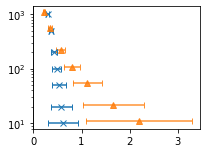

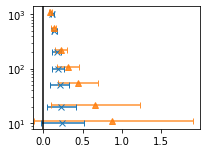

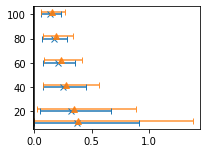

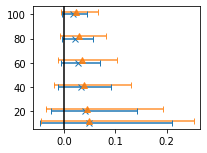

In [8]:
for params in params_list:

    result = (
        get_normal_t_improvement_against_M(
            N=params['N'], mu_X=params['mu_X'], sigma_X=params['sigma_X'],
            mu_epsilon=params['mu_eps'], sigma_1=params['sigma_1'], 
            sigma_2=params['sigma_2'], M_list=params['M'], verbose=True)
    )

    fig, ax = generate_normal_t_improvement_against_M_plot(params['M'], result)
    
    fig.set_size_inches(3, 2.25)
    fig.savefig("./output/fig/t_case_study_{}_{}_{}.pdf"
                .format(params['name'],
                        str(params['sigma_1']).replace('.', '-'),
                        str(params['sigma_2']).replace('.', '-')),
                transparent=True, bbox_inches='tight')

# General runs

In [5]:
def print_run_setting(count, N, M, mu_X, sigma_X, mu_eps, sigma_1, sigma_2):
     print("Cycle {}: N = {}, M = {}, mu_X = {}, sigma_X = {}, "
           "mu_epsilon = {}, sigma_1 = {}, sigma_2 = {}"
           .format(count, N, M, np.round(mu_X, 4), 
                   np.round(sigma_X, 4), np.round(mu_eps, 4),
                   np.round(sigma_1, 4), np.round(sigma_2, 4)))
 

def calculate_norm_and_t_improvements(cycles=100):
    # Constants
    NUM_RUNS = 1000
    T_DF = 3
    CI_HIGH_PERCENTILE = 95
    CI_LOW_PERCENTILE = 5  
    
    # Initialise empty list to hold the results
    normal_E_Ds = []
    normal_CI_lows = []
    normal_CI_highs = []
    t_E_Ds = []
    t_CI_lows = []
    t_CI_highs = []
    
    for cycle in range(1, cycles + 1, 1):
        params = get_test_params()
        N = int(params['N'])
        M = int(params['M'])
        mu_X = params['mu_X']
        mu_epsilon = params['mu_epsilon']
        sigma_sq_X = params['sigma_sq_X']
        sigma_sq_1 = params['sigma_sq_1']
        sigma_sq_2 = params['sigma_sq_2']

        # Reconciling the use of sigmas by numpy
        # and sigma_sqs in the theoretical calculations
        sigma_X = np.sqrt(sigma_sq_X)
        sigma_1 = np.sqrt(sigma_sq_1)
        sigma_2 = np.sqrt(sigma_sq_2)
    
        print_run_setting(cycle, N, M, mu_X, sigma_X,
                          mu_epsilon, sigma_1, sigma_2)
    
        # Normal assumptions
        normal_improvement = (
            nnm.get_samples(
                n_samples=NUM_RUNS, N=N, M=M, 
                mu_X=mu_X, mu_epsilon=mu_epsilon, 
                sigma_sq_X=sigma_sq_X, sigma_sq_1=sigma_sq_1,
                sigma_sq_2=sigma_sq_2, verbose=False)['improvement']
        )

        normal_E_D = np.mean(normal_improvement)
        normal_CI_low = np.percentile(normal_improvement, CI_LOW_PERCENTILE)
        normal_CI_high = np.percentile(normal_improvement, CI_HIGH_PERCENTILE)

        normal_E_Ds.append(normal_E_D)
        normal_CI_lows.append(normal_CI_low)
        normal_CI_highs.append(normal_CI_high)
        
        # t-assumptions
        t_improvement = (
            ttm.get_samples(
                n_samples=NUM_RUNS, N=N, M=M, 
                mu_X=mu_X, mu_epsilon=mu_epsilon, 
                sigma_sq_X=sigma_sq_X, sigma_sq_1=sigma_sq_1,
                sigma_sq_2=sigma_sq_2, nu=T_DF, verbose=False)['improvement']
        )
        
        t_E_D = np.mean(t_improvement)
        t_CI_low = np.percentile(t_improvement, 5)
        t_CI_high = np.percentile(t_improvement, 95)

        t_E_Ds.append(t_E_D)
        t_CI_lows.append(t_CI_low)
        t_CI_highs.append(t_CI_high)
    
        print("Cycle {}: Normal E(D) = {}; t E(D) = {}"
             .format(cycle, normal_E_D, t_E_D))
        
    # Prepare result in a dict
    result = {
        'normal_E_Ds': normal_E_Ds,
        'normal_CI_lows': normal_CI_lows,
        'normal_CI_highs': normal_CI_highs,
        't_E_Ds': t_E_Ds,
        't_CI_lows': t_CI_lows,
        't_CI_highs': t_CI_highs,
    }
            
    return result

In [60]:
calculate_norm_and_t_improvements(cycles=10)

Cycle 1: N = 743, M = 329, mu_X = 3.7665, sigma_X = 9.221, mu_epsilon = -0.0438, sigma_1 = 8.863, sigma_2 = 2.9277
Cycle 1: Normal E(D) = 1.8975043738303834; t E(D) = 0.696125145049461
Cycle 2: N = 2576, M = 830, mu_X = 1.2699, sigma_X = 2.1169, mu_epsilon = -4.2157, sigma_1 = 2.0734, sigma_2 = 0.5917
Cycle 2: Normal E(D) = 0.5857895746468357; t E(D) = 0.2244220866944466
Cycle 3: N = 558, M = 382, mu_X = -4.3298, sigma_X = 5.2404, mu_epsilon = 5.2075, sigma_1 = 5.5045, sigma_2 = 5.3395
Cycle 3: Normal E(D) = 0.030380646754874355; t E(D) = 0.008654740933419353
Cycle 4: N = 2515, M = 1366, mu_X = -3.8029, sigma_X = 4.7719, mu_epsilon = 8.8466, sigma_1 = 8.294, sigma_2 = 7.5481
Cycle 4: Normal E(D) = 0.11917893642517761; t E(D) = 0.044937624633430574
Cycle 5: N = 73, M = 37, mu_X = -1.5309, sigma_X = 3.0347, mu_epsilon = -0.5342, sigma_1 = 5.5688, sigma_2 = 4.7152
Cycle 5: Normal E(D) = 0.1466374567223039; t E(D) = 0.06419475746459284
Cycle 6: N = 18, M = 5, mu_X = 5.8109, sigma_X = 6.585

{'normal_E_Ds': [1.8975043738303834,
  0.5857895746468357,
  0.030380646754874355,
  0.11917893642517761,
  0.1466374567223039,
  0.6283847114051593,
  1.0481782855579986,
  0.039081474760881744,
  0.7601320850848359,
  0.06622997105372495],
 'normal_CI_lows': [1.554117754211027,
  0.5298329567107,
  -0.16024247684374232,
  -0.032312773304483705,
  -0.4696363601393994,
  -1.760415791234639,
  0.8917353550097207,
  -0.06414662529003909,
  0.6087667813758106,
  0.04708183768946075],
 'normal_CI_highs': [2.233280704687485,
  0.639956496556603,
  0.22335257300775102,
  0.2692829857359111,
  0.7766349608135799,
  3.3206495632028967,
  1.2078238967546737,
  0.14388196509369147,
  0.9118124909525646,
  0.08670451321290215],
 't_E_Ds': [0.696125145049461,
  0.2244220866944466,
  0.008654740933419353,
  0.044937624633430574,
  0.06419475746459284,
  0.19595238046646699,
  0.40322032109700273,
  0.02535315344571938,
  0.26489588393905356,
  0.040066118286449445],
 't_CI_lows': [0.544481113313480